## Problem Statement : Wether Forecasting for univariate


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import datetime,timedelta

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN, LSTM, GRU
import tensorflow as tf
from datetime import datetime

2022-04-29 17:09:01.225650: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-29 17:09:01.225731: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
data = pd.read_csv('aggregated_hourly_data.csv')

In [ ]:
data.shape

(2962043, 28)

In [ ]:
data_model = data[0:100000] 

In [ ]:
data_temp = data_model[['date','temp']]
data_temp

,date,temp
0,2007-12-31 02:00:00,9.2
1,2007-12-31 03:00:00,9.3
2,2007-12-31 04:00:00,9.3
3,2007-12-31 05:00:00,9.6
4,2007-12-31 06:00:00,9.8
...,...,...
99995,2019-05-28 13:00:00,13.2
99996,2019-05-28 14:00:00,14.2
99997,2019-05-28 15:00:00,14.6
99998,2019-05-28 16:00:00,13.9


In [ ]:
data_temp.isnull().sum()

date    0
temp    0
dtype: int64

In [ ]:
# convert time data into datetime
data_temp['date']=pd.to_datetime(data_temp['date'])

/tmp/ipykernel_3543/1778272325.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp['date']=pd.to_datetime(data_temp['date'])


In [ ]:
# Set Datetime feature as index
data_temp.set_index('date',inplace=True)
data_temp.head()

,temp
date,
2007-12-31 02:00:00,9.2
2007-12-31 03:00:00,9.3
2007-12-31 04:00:00,9.3
2007-12-31 05:00:00,9.6
2007-12-31 06:00:00,9.8


In [ ]:
data_temp.shape

(100000, 1)

In [ ]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100000 entries, 2007-12-31 02:00:00 to 2019-05-28 17:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   temp    100000 non-null  float64
dtypes: float64(1)
memory usage: 1.5 MB


In [ ]:
data_temp.describe()

,temp
count,100000.000000
mean,9.969327
std,5.263679
min,-10.400000
25%,6.200000
50%,10.100000
75%,13.800000
max,28.300000


<AxesSubplot:xlabel='date'>

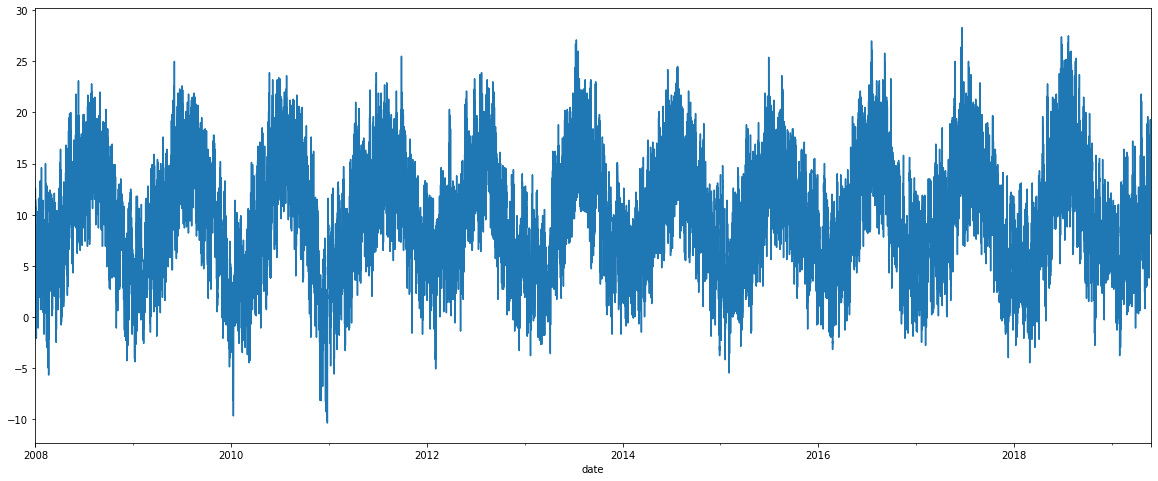

In [ ]:
data_temp.temp.plot(figsize = (20,8))

<AxesSubplot:xlabel='date'>

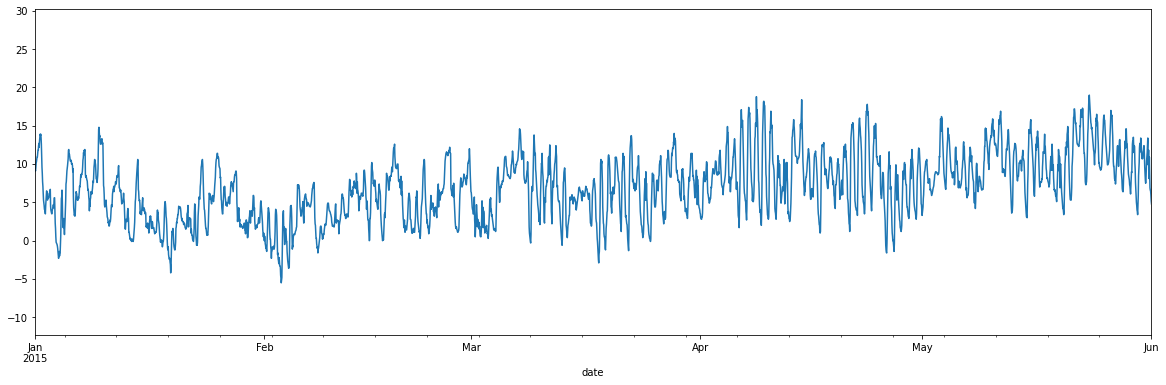

In [ ]:
## xlimit and ylimit to plot
data_temp['temp'].plot(xlim=['2015-01-01','2015-06-01'],figsize=(20,6))

<AxesSubplot:xlabel='date'>

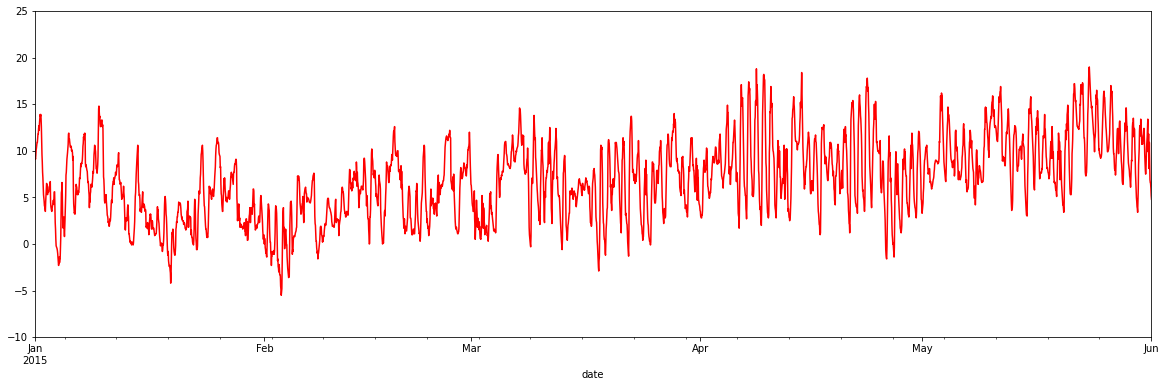

In [ ]:
data_temp['temp'].plot(xlim=['2015-01-01','2015-06-01'],ylim = [-10,25], figsize=(20,6),c='r')

In [ ]:
year = set(pd.DatetimeIndex(data_temp.index).year)
print(year)

{2016, 2017, 2018, 2019, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015}


In [ ]:
month = set(pd.DatetimeIndex(data_temp.index).month)
print(month)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12}


In [ ]:
day = set(pd.DatetimeIndex(data_temp.index).day)
print(day)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31}


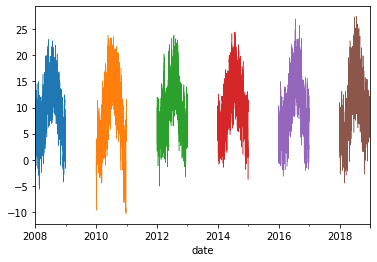

In [ ]:
data_temp.loc['2008']['temp'].plot(linewidth=0.5);
data_temp.loc['2010']['temp'].plot(linewidth=0.5);
data_temp.loc['2012']['temp'].plot(linewidth=0.5);
data_temp.loc['2014']['temp'].plot(linewidth=0.5);
data_temp.loc['2016']['temp'].plot(linewidth=0.5);
data_temp.loc['2018']['temp'].plot(linewidth=0.5);

In [ ]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
    result=adfuller(series)
    print('ADF Statistics: {}'.format(result[0]))
    print('p- value: {}'.format(result[1]))
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
        

In [ ]:
adf_test(data_temp['temp'])

ADF Statistics: -10.219963252551118
p- value: 5.356909944727293e-18
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


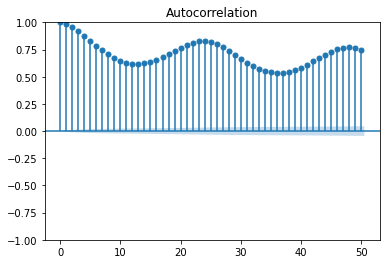

In [ ]:
acf = plot_acf(data_temp["temp"])

/home/neosoft/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


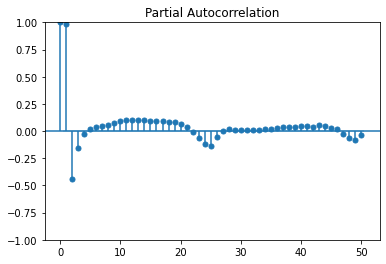

In [ ]:
pacf = plot_pacf(data_temp["temp"])

In [ ]:
result = seasonal_decompose(data_temp['temp'])

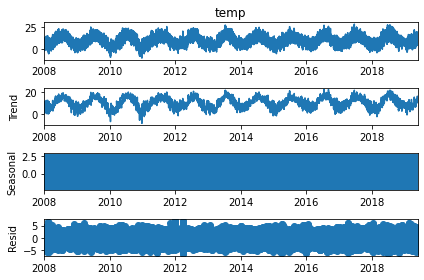

In [ ]:
result.plot();

### split data into train test

In [ ]:
train_dataset_end = datetime(2018,12,31)
timedelta(days=1)

datetime.timedelta(days=1)

In [ ]:
train_data = data_temp[:train_dataset_end]
test_data = data_temp[train_dataset_end+timedelta(days=1):]

In [ ]:
train_data

,temp
date,
2007-12-31 02:00:00,9.2
2007-12-31 03:00:00,9.3
2007-12-31 04:00:00,9.3
2007-12-31 05:00:00,9.6
2007-12-31 06:00:00,9.8
...,...
2018-12-30 20:00:00,10.2
2018-12-30 21:00:00,10.3
2018-12-30 22:00:00,10.3


In [ ]:
scaler = MinMaxScaler()
scaler.fit(train_data)
scaler_train = scaler.transform(train_data)
scaler_test = scaler.transform(test_data)

In [ ]:
scaler_train

array([[0.50645995],
       [0.50904393],
       [0.50904393],
       ...,
       [0.53488372],
       [0.52971576],
       [0.51421189]])

In [ ]:
scaler_test

array([[0.51679587],
       [0.49095607],
       [0.48320413],
       ...,
       [0.64599483],
       [0.62790698],
       [0.65633075]])

In [ ]:
print(scaler_train.shape)
print(scaler_test.shape)

(96431, 1)
(3546, 1)


In [ ]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaler_train, scaler_train, length = n_input, batch_size = 32)

In [ ]:
model_gru = Sequential()
model_gru.add(GRU(128, return_sequences=True, input_shape= (n_input, n_features), activation="tanh"))
model_gru.add(GRU(units=64, return_sequences=True,activation="tanh"))
model_gru.add(GRU(units=32, activation="tanh"))

model_gru.add(Dense(units=1))

model_gru.compile(loss='mse', optimizer='adam')

2022-04-29 17:15:16.232122: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-29 17:15:16.233122: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-29 17:15:16.234496: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (neosoft-ThinkPad-X260): /proc/driver/nvidia/version does not exist
2022-04-29 17:15:16.255699: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
model_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 12, 128)           50304     
                                                                 
 gru_1 (GRU)                 (None, 12, 64)            37248     
                                                                 
 gru_2 (GRU)                 (None, 32)                9408      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 96,993
Trainable params: 96,993
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_gru.get_weights()

[array([[ 0.10106931,  0.08094152,  0.11344979,  0.12418991,  0.04160159,
          0.11500134, -0.07696269, -0.0289989 ,  0.09466731, -0.12270303,
         -0.02787226,  0.0886311 ,  0.02326982,  0.03344145, -0.03676021,
         -0.009659  , -0.02901912,  0.08218329,  0.04839159,  0.0502942 ,
          0.11716614, -0.01958581,  0.03455443, -0.06566167,  0.11092671,
         -0.0772133 , -0.0533813 , -0.04536939, -0.00194969, -0.09970604,
          0.04496302, -0.11101805, -0.11336193,  0.00705094, -0.0783584 ,
         -0.06448428, -0.07700395, -0.07494297,  0.12399123, -0.12154151,
          0.01540727, -0.05525929,  0.04079109, -0.08097275,  0.06534614,
          0.10380321,  0.04636636, -0.02436697, -0.08105698, -0.08837492,
          0.08059784, -0.0707888 , -0.03070058, -0.01058521,  0.02489796,
         -0.07193971, -0.07458355, -0.02027112,  0.05651047,  0.00203035,
         -0.02966088, -0.01303797, -0.01420354,  0.10558712, -0.08517492,
         -0.11074813,  0.06690537, -0.

In [ ]:
# fit network
gru_history = model_gru.fit(generator, epochs=15)

Epoch 1/15
3014/3014 [==============================] - 59s 18ms/step - loss: 9.8522e-04
Epoch 2/15
3014/3014 [==============================] - 61s 20ms/step - loss: 5.1033e-04
Epoch 3/15
3014/3014 [==============================] - 63s 21ms/step - loss: 4.8713e-04
Epoch 4/15
3014/3014 [==============================] - 61s 20ms/step - loss: 4.8438e-04
Epoch 5/15
3014/3014 [==============================] - 65s 22ms/step - loss: 4.6317e-04
Epoch 6/15
3014/3014 [==============================] - 71s 24ms/step - loss: 4.5287e-04
Epoch 7/15
3014/3014 [==============================] - 68s 22ms/step - loss: 4.4612e-04
Epoch 8/15
3014/3014 [==============================] - 61s 20ms/step - loss: 4.4880e-04
Epoch 9/15
3014/3014 [==============================] - 60s 20ms/step - loss: 4.4528e-04
Epoch 10/15
3014/3014 [==============================] - 59s 20ms/step - loss: 4.3768e-04
Epoch 11/15
3014/3014 [==============================] - 62s 21ms/step - loss: 4.3611e-04
Epoch 12/15
3014/30

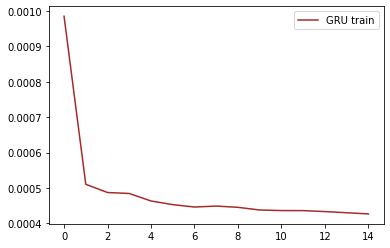

In [ ]:
plt.plot(gru_history.history['loss'], label='GRU train', color='brown')

plt.legend()
plt.show()

In [ ]:
pred_test =  model_gru.predict(scaler_test)
pred_test.shape

(3546, 1)

In [ ]:
pred_test

array([[0.61751497],
       [0.57636774],
       [0.5639033 ],
       ...,
       [0.80575544],
       [0.7816297 ],
       [0.8191765 ]], dtype=float32)

In [ ]:
pred_train =  model_gru.predict(scaler_train)
pred_train.shape

(96431, 1)

In [ ]:
train_predict = scaler.inverse_transform(pred_train)
train_predict

array([[12.864229],
       [13.023094],
       [13.023094],
       ...,
       [14.593177],
       [14.282132],
       [13.339906]], dtype=float32)

In [ ]:
test_predict = scaler.inverse_transform(pred_test)
test_predict

array([[13.4978285],
       [11.905431 ],
       [11.423057 ],
       ...,
       [20.782736 ],
       [19.849068 ],
       [21.30213  ]], dtype=float32)

In [ ]:
train_data['gru_predict'] = train_predict

/tmp/ipykernel_3543/2514482628.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['gru_predict'] = train_predict


In [ ]:
train_data.head()

,temp,gru_predict
date,,
2007-12-31 02:00:00,9.2,12.864229
2007-12-31 03:00:00,9.3,13.023094
2007-12-31 04:00:00,9.3,13.023094
2007-12-31 05:00:00,9.6,13.497828
2007-12-31 06:00:00,9.8,13.812643


<AxesSubplot:xlabel='date'>

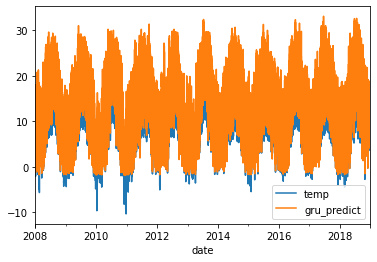

In [ ]:
train_data.plot(figsize = (20,8))

In [ ]:
test_data['gru_predict'] = test_predict
test_data.head()

/tmp/ipykernel_3543/743980131.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['gru_predict'] = test_predict


,temp,gru_predict
date,,
2019-01-01 00:00:00,9.6,13.497828
2019-01-01 01:00:00,8.6,11.905431
2019-01-01 02:00:00,8.3,11.423057
2019-01-01 03:00:00,9.1,12.705076
2019-01-01 04:00:00,9.2,12.864229


<AxesSubplot:xlabel='date'>

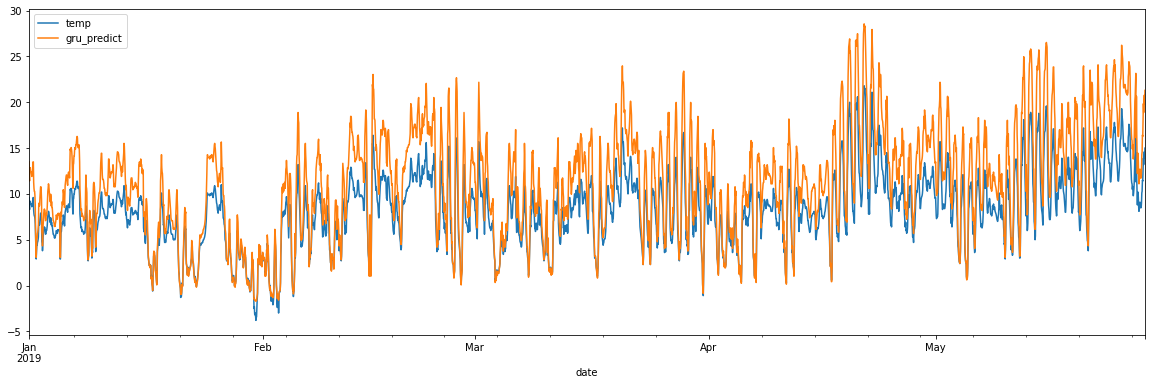

In [ ]:
test_data.plot(figsize= (20,8))

In [ ]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
r2_score1 = r2_score(train_data['temp'],train_predict)
gru = {'Model':'GRU_train','MAE': mean_absolute_error(train_data['temp'],train_predict),"MSE":mean_squared_error(train_data['temp'],train_predict),'RMSE':np.sqrt(mean_squared_error(train_data['temp'],train_predict)),'r2_score':r2_score1}
evl_metric_gru_train = pd.DataFrame((gru),columns=['Model','MAE','MSE','RMSE','r2_score'],index=[0])

evl_metric_gru_train

,Model,MAE,MSE,RMSE,r2_score
0,GRU_train,3.875907,20.109314,4.484341,0.282348


In [ ]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
r2_score1 = r2_score(test_data['temp'],test_predict)
gru = {'Model':'GRU_train','MAE': mean_absolute_error(test_data['temp'],test_predict),
       "MSE":mean_squared_error(test_data['temp'],test_predict),
       'RMSE':np.sqrt(mean_squared_error(test_data['temp'],test_predict)),
       'r2_score':r2_score1}
evl_metric_gru_test = pd.DataFrame((gru),columns=['Model','MAE','MSE','RMSE','r2_score'],index=[0])

evl_metric_gru_test

,Model,MAE,MSE,RMSE,r2_score
0,GRU_train,3.04756,12.878572,3.588673,0.193738


## LSTM- TImeSeries

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(128, return_sequences=True, input_shape= (n_input, n_features),activation = "tanh"))
model_lstm.add(LSTM(units=64, return_sequences=True, activation = "tanh"))
model_lstm.add(LSTM(units=32, activation = "tanh"))
model_lstm.add(Dense(units=1))

model_lstm.compile(loss='mse', optimizer='adam')

In [ ]:
# fit network
lstm_history = model_lstm.fit(generator, epochs=15)

Epoch 1/15
3014/3014 [==============================] - 68s 22ms/step - loss: 6.8920e-04
Epoch 2/15
3014/3014 [==============================] - 69s 23ms/step - loss: 4.9242e-04
Epoch 3/15
3014/3014 [==============================] - 71s 23ms/step - loss: 4.7338e-04
Epoch 4/15
3014/3014 [==============================] - 66s 22ms/step - loss: 4.5896e-04
Epoch 5/15
3014/3014 [==============================] - 65s 21ms/step - loss: 4.4673e-04
Epoch 6/15
3014/3014 [==============================] - 63s 21ms/step - loss: 4.4694e-04
Epoch 7/15
3014/3014 [==============================] - 67s 22ms/step - loss: 4.3785e-04
Epoch 8/15
3014/3014 [==============================] - 64s 21ms/step - loss: 4.3464e-04
Epoch 9/15
3014/3014 [==============================] - 68s 23ms/step - loss: 4.3703e-04
Epoch 10/15
3014/3014 [==============================] - 69s 23ms/step - loss: 4.3114e-04
Epoch 11/15
3014/3014 [==============================] - 66s 22ms/step - loss: 4.2542e-04
Epoch 12/15
3014/30

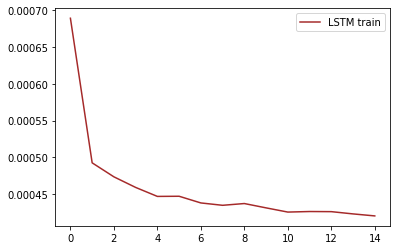

In [ ]:
plt.plot(lstm_history.history['loss'], label='LSTM train', color='brown')

plt.legend()
plt.show()

In [ ]:
pred_test_lstm =  model_lstm.predict(scaler_test)
pred_test_lstm.shape

(3546, 1)

In [ ]:
pred_test_lstm

array([[0.5706342],
       [0.5332791],
       [0.5217435],
       ...,
       [0.7277176],
       [0.7087935],
       [0.7380947]], dtype=float32)

In [ ]:
test_predict_lstm = scaler.inverse_transform(pred_test_lstm)
test_predict_lstm

array([[11.683542],
       [10.237902],
       [ 9.791472],
       ...,
       [17.76267 ],
       [17.03031 ],
       [18.164265]], dtype=float32)

In [ ]:
pred_train_lstm =  model_lstm.predict(scaler_train)
pred_train_lstm.shape

(96431, 1)

In [ ]:
train_predict_lstm = scaler.inverse_transform(pred_train_lstm)
train_predict_lstm

array([[11.113529],
       [11.257098],
       [11.257098],
       ...,
       [12.652795],
       [12.379628],
       [11.542112]], dtype=float32)

In [ ]:
train_data['lstm_predict'] = train_predict_lstm

/tmp/ipykernel_3543/4042878964.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['lstm_predict'] = train_predict_lstm


In [ ]:
train_data

,temp,gru_predict,lstm_predict
date,,,
2007-12-31 02:00:00,9.2,12.864229,11.113529
2007-12-31 03:00:00,9.3,13.023094,11.257098
2007-12-31 04:00:00,9.3,13.023094,11.257098
2007-12-31 05:00:00,9.6,13.497828,11.683542
2007-12-31 06:00:00,9.8,13.812643,11.964208
...,...,...,...
2018-12-30 20:00:00,10.2,14.437858,12.516589
2018-12-30 21:00:00,10.3,14.593177,12.652793
2018-12-30 22:00:00,10.3,14.593177,12.652795


In [ ]:
test_data['lstm_predict'] = test_predict_lstm

/tmp/ipykernel_3543/722168332.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['lstm_predict'] = test_predict_lstm


In [ ]:
test_data

,temp,gru_predict,lstm_predict
date,,,
2019-01-01 00:00:00,9.6,13.497828,11.683542
2019-01-01 01:00:00,8.6,11.905431,10.237902
2019-01-01 02:00:00,8.3,11.423057,9.791472
2019-01-01 03:00:00,9.1,12.705076,10.969269
2019-01-01 04:00:00,9.2,12.864229,11.113529
...,...,...,...
2019-05-28 13:00:00,13.2,18.884630,16.259722
2019-05-28 14:00:00,14.2,20.253029,17.348820
2019-05-28 15:00:00,14.6,20.782736,17.762671


<AxesSubplot:xlabel='date'>

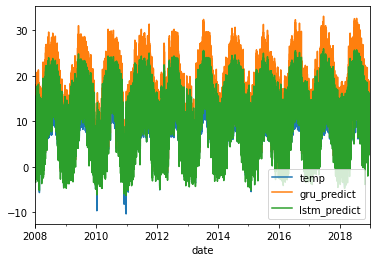

In [ ]:
train_data.plot(figsize = (20,8))

<AxesSubplot:xlabel='date'>

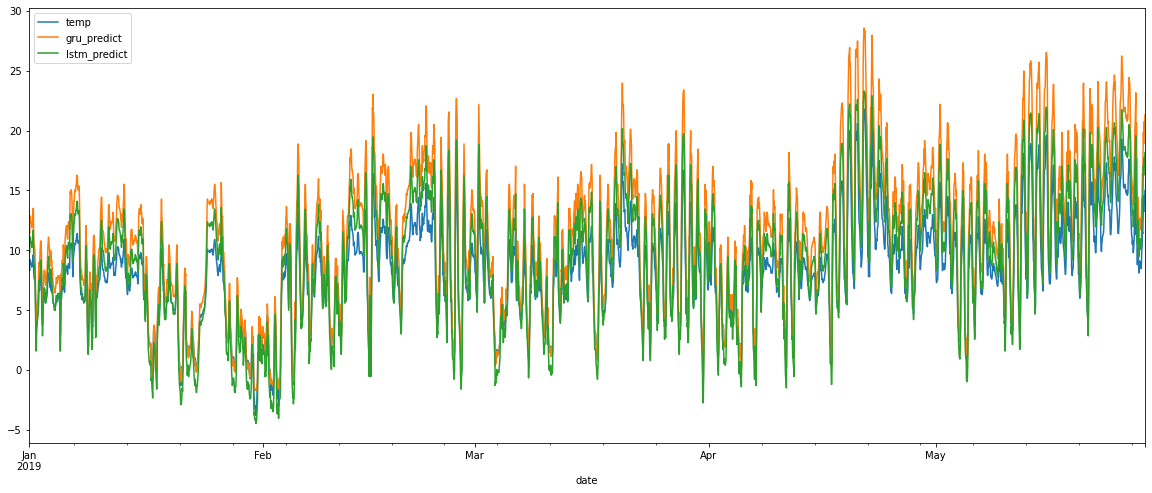

In [ ]:
test_data.plot(figsize = (20,8))

In [ ]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
r2_score1 = r2_score(train_data['temp'],train_predict_lstm)
lstm = {'Model':'LSTM_train','MAE': mean_absolute_error(train_data['temp'],train_predict_lstm),
       "MSE":mean_squared_error(train_data['temp'],train_predict_lstm),
       'RMSE':np.sqrt(mean_squared_error(train_data['temp'],train_predict_lstm)),'r2_score':r2_score1}
evl_metric_lstm_train = pd.DataFrame((lstm),columns=['Model','MAE','MSE','RMSE','r2_score'],index=[0])

evl_metric_lstm_train

,Model,MAE,MSE,RMSE,r2_score
0,LSTM_train,2.014901,5.005357,2.237265,0.821371


In [ ]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
r2_score1 = r2_score(test_data['temp'],test_predict_lstm)
lstm = {'Model':'LSTM_test','MAE': mean_absolute_error(test_data['temp'],test_predict_lstm),
       "MSE":mean_squared_error(test_data['temp'],test_predict_lstm),
       'RMSE':np.sqrt(mean_squared_error(test_data['temp'],test_predict_lstm)),'r2_score':r2_score1}
evl_metric_lstm_test = pd.DataFrame((lstm),columns=['Model','MAE','MSE','RMSE','r2_score'],index=[0])

evl_metric_lstm_test

,Model,MAE,MSE,RMSE,r2_score
0,LSTM_test,1.660684,3.590629,1.894896,0.775209


## RNN Model

In [ ]:
model_rnn = Sequential()
model_rnn.add(SimpleRNN(128, return_sequences=True, input_shape= (n_input, n_features),activation = "tanh"))
model_rnn.add(SimpleRNN(units=64, return_sequences=True,activation = "tanh"))
model_rnn.add(SimpleRNN(units=32, activation = "tanh"))
model_rnn.add(Dense(units=1))

model_rnn.compile(loss='mse', optimizer='adam')

In [ ]:
# fit network
rnn_history = model_rnn.fit(generator, epochs=15)

Epoch 1/15
3014/3014 [==============================] - 26s 8ms/step - loss: 0.0027
Epoch 2/15
3014/3014 [==============================] - 26s 9ms/step - loss: 7.5014e-04
Epoch 3/15
3014/3014 [==============================] - 26s 9ms/step - loss: 6.8839e-04
Epoch 4/15
3014/3014 [==============================] - 25s 8ms/step - loss: 6.1076e-04
Epoch 5/15
3014/3014 [==============================] - 25s 8ms/step - loss: 0.0024
Epoch 6/15
3014/3014 [==============================] - 25s 8ms/step - loss: 8.2391e-04
Epoch 7/15
3014/3014 [==============================] - 25s 8ms/step - loss: 6.5820e-04
Epoch 8/15
3014/3014 [==============================] - 28s 9ms/step - loss: 6.3313e-04
Epoch 9/15
3014/3014 [==============================] - 25s 8ms/step - loss: 7.3934e-04
Epoch 10/15
3014/3014 [==============================] - 26s 8ms/step - loss: 0.0093
Epoch 11/15
3014/3014 [==============================] - 33s 11ms/step - loss: 0.0202
Epoch 12/15
3014/3014 [======================

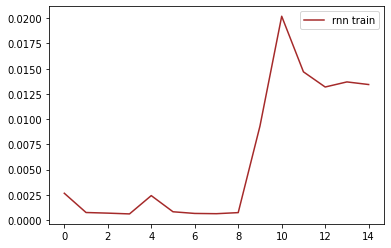

In [ ]:
plt.plot(rnn_history.history['loss'], label='rnn train', color='brown')

plt.legend()
plt.show()

In [ ]:
pred_test_rnn =  model_rnn.predict(scaler_test)
pred_test_rnn.shape

(3546, 1)

In [ ]:
pred_train_rnn =  model_rnn.predict(scaler_train)
pred_train_rnn.shape

(96431, 1)

In [ ]:
test_predict_rnn = scaler.inverse_transform(pred_test_rnn)
test_predict_rnn

array([[ 0.34714252],
       [-0.25072753],
       [-0.4252432 ],
       ...,
       [ 5.0705686 ],
       [ 4.1619773 ],
       [ 5.626918  ]], dtype=float32)

In [ ]:
train_predict_rnn = scaler.inverse_transform(pred_train_rnn)
train_predict_rnn

array([[0.10308444],
       [0.16329162],
       [0.16329162],
       ...,
       [0.80125904],
       [0.6672663 ],
       [0.28527796]], dtype=float32)

In [ ]:
test_data['rnn_predict'] = test_predict_rnn

/tmp/ipykernel_3543/2617015557.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['rnn_predict'] = test_predict_rnn


In [ ]:
train_data['rnn_predict'] = train_predict_rnn

/tmp/ipykernel_3543/80071372.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['rnn_predict'] = train_predict_rnn


<AxesSubplot:xlabel='date'>

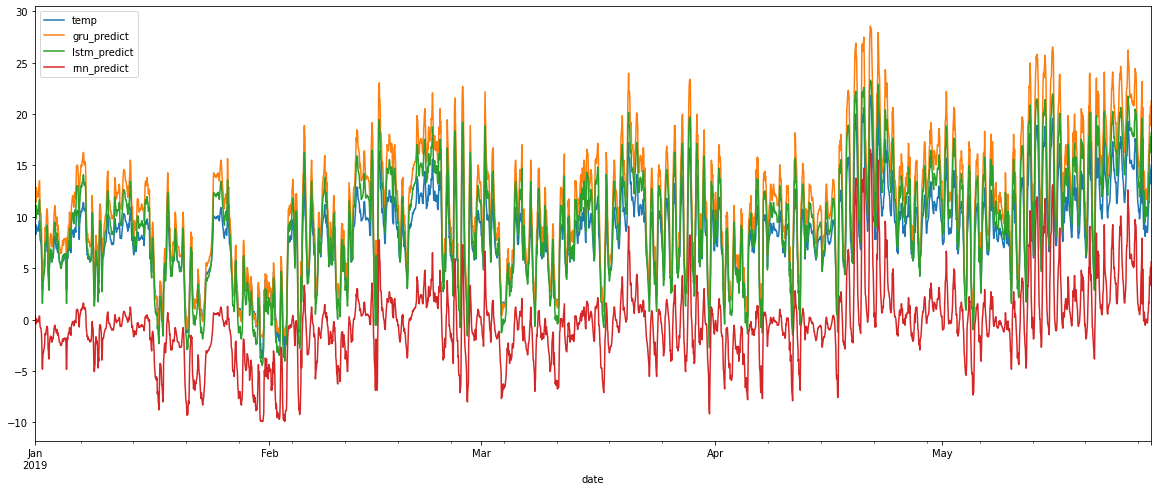

In [ ]:
test_data.plot(figsize = (20,8))

<AxesSubplot:xlabel='date'>

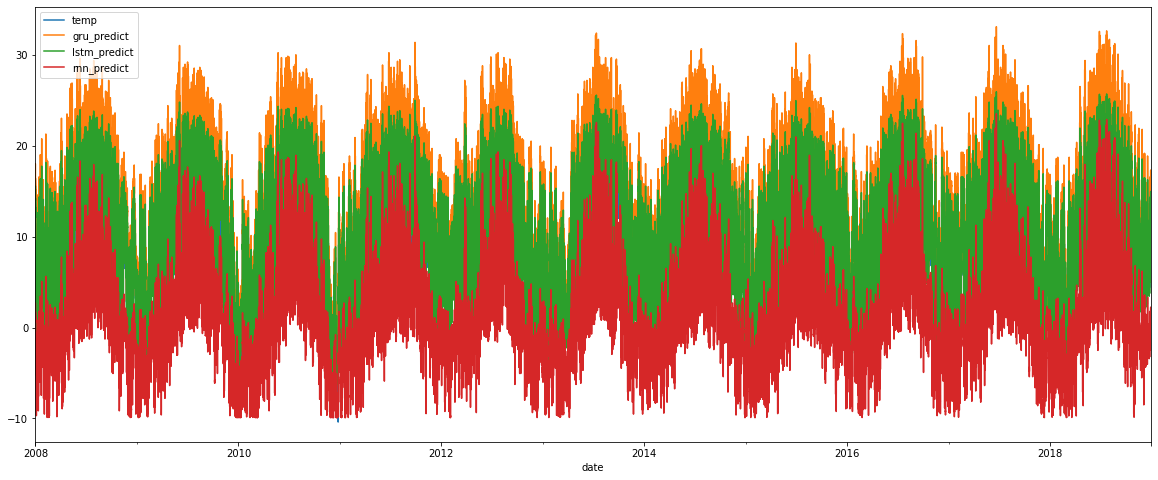

In [ ]:
train_data.plot(figsize = (20,8))

In [ ]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
r2_score1 = r2_score(train_data['temp'],train_predict_rnn)
rnn = {'Model':'RNN_train','MAE': mean_absolute_error(train_data['temp'],train_predict_rnn),
       "MSE":mean_squared_error(train_data['temp'],train_predict_rnn),
       'RMSE':np.sqrt(mean_squared_error(train_data['temp'],train_predict_rnn)),'r2_score':r2_score1}
evl_metric_rnn_train = pd.DataFrame((rnn),columns=['Model','MAE','MSE','RMSE','r2_score'],index=[0])

evl_metric_rnn_train

,Model,MAE,MSE,RMSE,r2_score
0,RNN_train,8.64404,75.819489,8.707439,-1.705811


In [ ]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
r2_score1 = r2_score(test_data['temp'],test_predict_rnn)
rnn = {'Model':'RNN_test','MAE': mean_absolute_error(test_data['temp'],test_predict_rnn),
       "MSE":mean_squared_error(test_data['temp'],test_predict_rnn),
       'RMSE':np.sqrt(mean_squared_error(test_data['temp'],test_predict_rnn)),'r2_score':r2_score1}
evl_metric_rnn_test = pd.DataFrame((rnn),columns=['Model','MAE','MSE','RMSE','r2_score'],index=[0])

evl_metric_rnn_test

,Model,MAE,MSE,RMSE,r2_score
0,RNN_test,8.654256,75.551066,8.692012,-3.72987
